# Restricted Boltzmann Machine (RBM) for MNIST

This notebook demonstrates the training of a Restricted Boltzmann Machine (RBM) on the MNIST dataset using PyTorch.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models.rbm import RBM
from utils.rbm_utils import *

torch.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


## Load and Preprocess MNIST Dataset

We'll load the MNIST dataset using torchvision, convert the images to tensors, and normalize them. Since RBMs work with binary data, we'll binarize the images using a threshold.

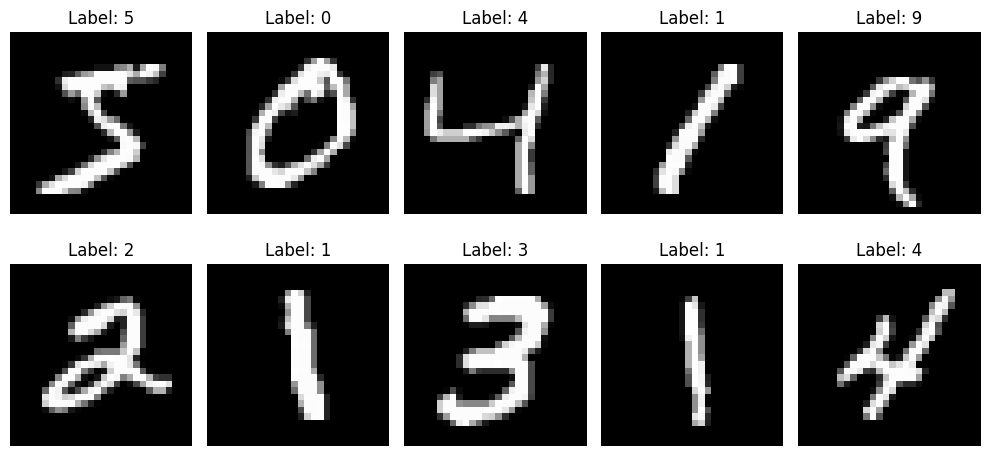

In [2]:
# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform=transform
)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

plt.figure(figsize=(10, 5))
for i in range(10):
    img = train_dataset[i][0].squeeze().numpy()
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {train_dataset[i][1]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Define RBM Model

Now we'll instantiate our RBM model using the class from `rbm.py`. For MNIST:
- n_visible = 784 (28x28 pixels flattened)
- n_hidden = 256 (a common choice for MNIST)
- training_method = "cd" (contrastive divergence)

In [3]:
# MNIST parameters
n_visible = 28 * 28  # Input dimensions (flattened 28x28 images)
n_hidden = 256  # Number of hidden units
training_method = "cd"  # Use Contrastive Divergence
# training_method = "mle"  # Use Maximum Likelihood Estimation

# Create the RBM
rbm = RBM(
    n_visible=n_visible,
    n_hidden=n_hidden,
    device=device,
    training_method=training_method,
)

print(f"RBM Configuration:")
print(f"Visible units: {n_visible}")
print(f"Hidden units: {n_hidden}")
print(f"Training method: {training_method}")

RBM using device: mps
RBM Configuration:
Visible units: 784
Hidden units: 256
Training method: cd


## Train RBM on MNIST

Now we'll train the RBM using the `train_rbm` method provided in the implementation. We need to ensure that we binarize the MNIST data before feeding it to the RBM.

In [4]:
# Create binarized data loader
binarized_train_loader = BinarizedDataLoader(train_loader)

# Train RBM
learning_rate = 0.01
k = 1  # Number of Gibbs sampling steps for CD-k
epochs = 10

# Train the model, explicitly record metrics
history = rbm.train_rbm(
    data_loader=binarized_train_loader,
    lr=learning_rate,
    k=k,
    epochs=epochs,
    record_metrics=True,
)

print(f"Training completed with final loss: {history['recon_error'][-1]:.4f}")

Training RBM using cd method


Epoch 10/10, Avg FE: -324.5370, Recon Err: 0.0271: 100%|██████████| 10/10 [00:37<00:00,  3.73s/it]

Training finished.
Training completed with final loss: 0.0271


## Visualize Training History

Let's visualize the training history to see how the RBM's performance improved over epochs. We'll plot two key metrics:
1. **Average Free Energy**: Represents the negative log-likelihood of the data under the model. Lower values indicate better model fit.
2. **Reconstruction Error**: Measures how well the model can reconstruct the original input data. Lower values indicate better reconstruction quality.

Training History Summary:
Epoch     Free Energy         Reconstruction Error
--------------------------------------------------
1         -199.3830           0.0555              
2         -234.0595           0.0402              
3         -255.1896           0.0360              
4         -270.3940           0.0335              
5         -282.5506           0.0318              
6         -292.6535           0.0304              
7         -301.8316           0.0294              
8         -310.2016           0.0285              
9         -317.6215           0.0277              
10        -324.5370           0.0271              


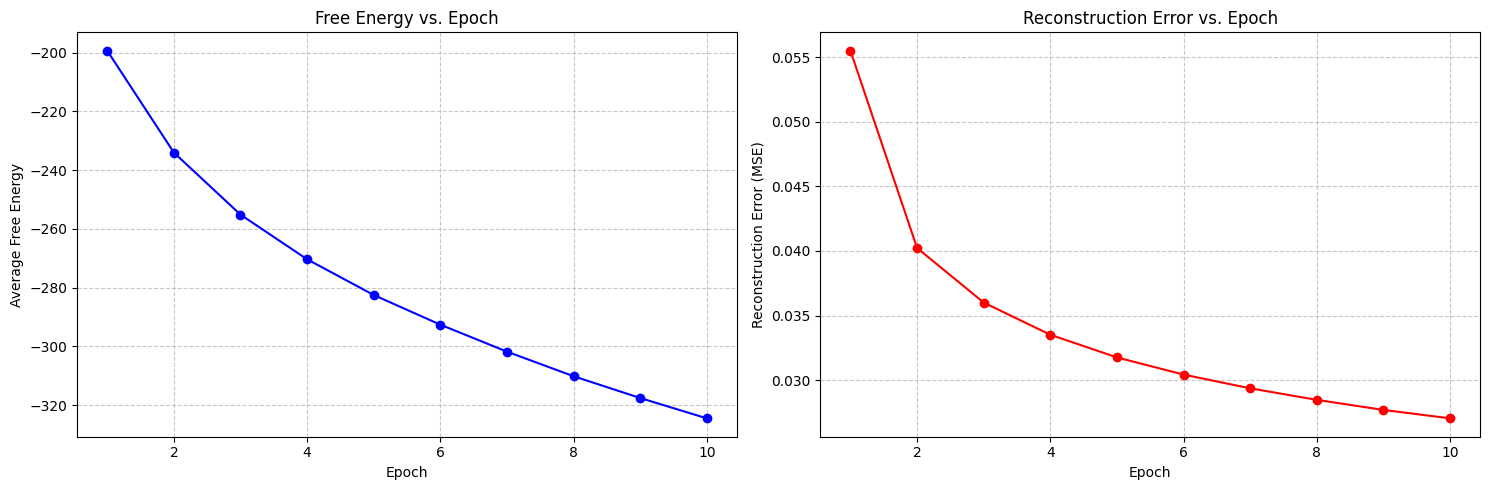


Overall Improvements:
Free Energy: 62.77%
Reconstruction Error: 51.23%


In [5]:
visualize_training_history(history)

## Visualize Learned Features

The weights of an RBM can be visualized as filters that are activated by specific patterns in the input. By reshaping each row of the weight matrix to the input dimensions (28x28), we can see what features the RBM has learned to detect.

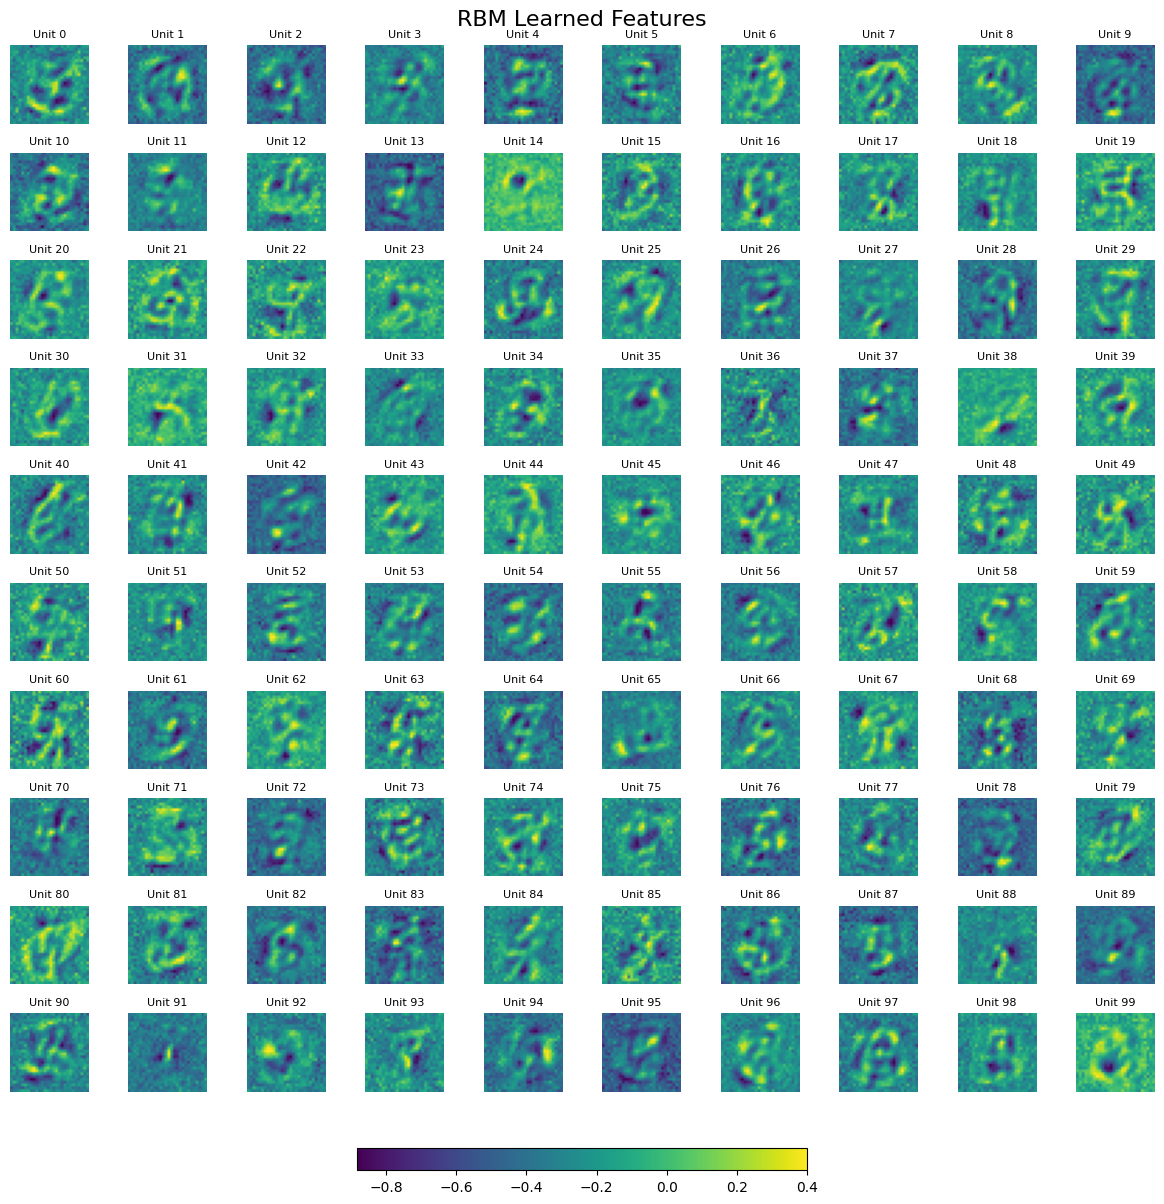

In [6]:
visualize_weights(rbm);

## Relate Learned Features to Digit Classes

To better understand which features correspond to which digits, we'll analyze the activations of hidden units for different digit classes. This will show us which features are most strongly activated by each digit class.

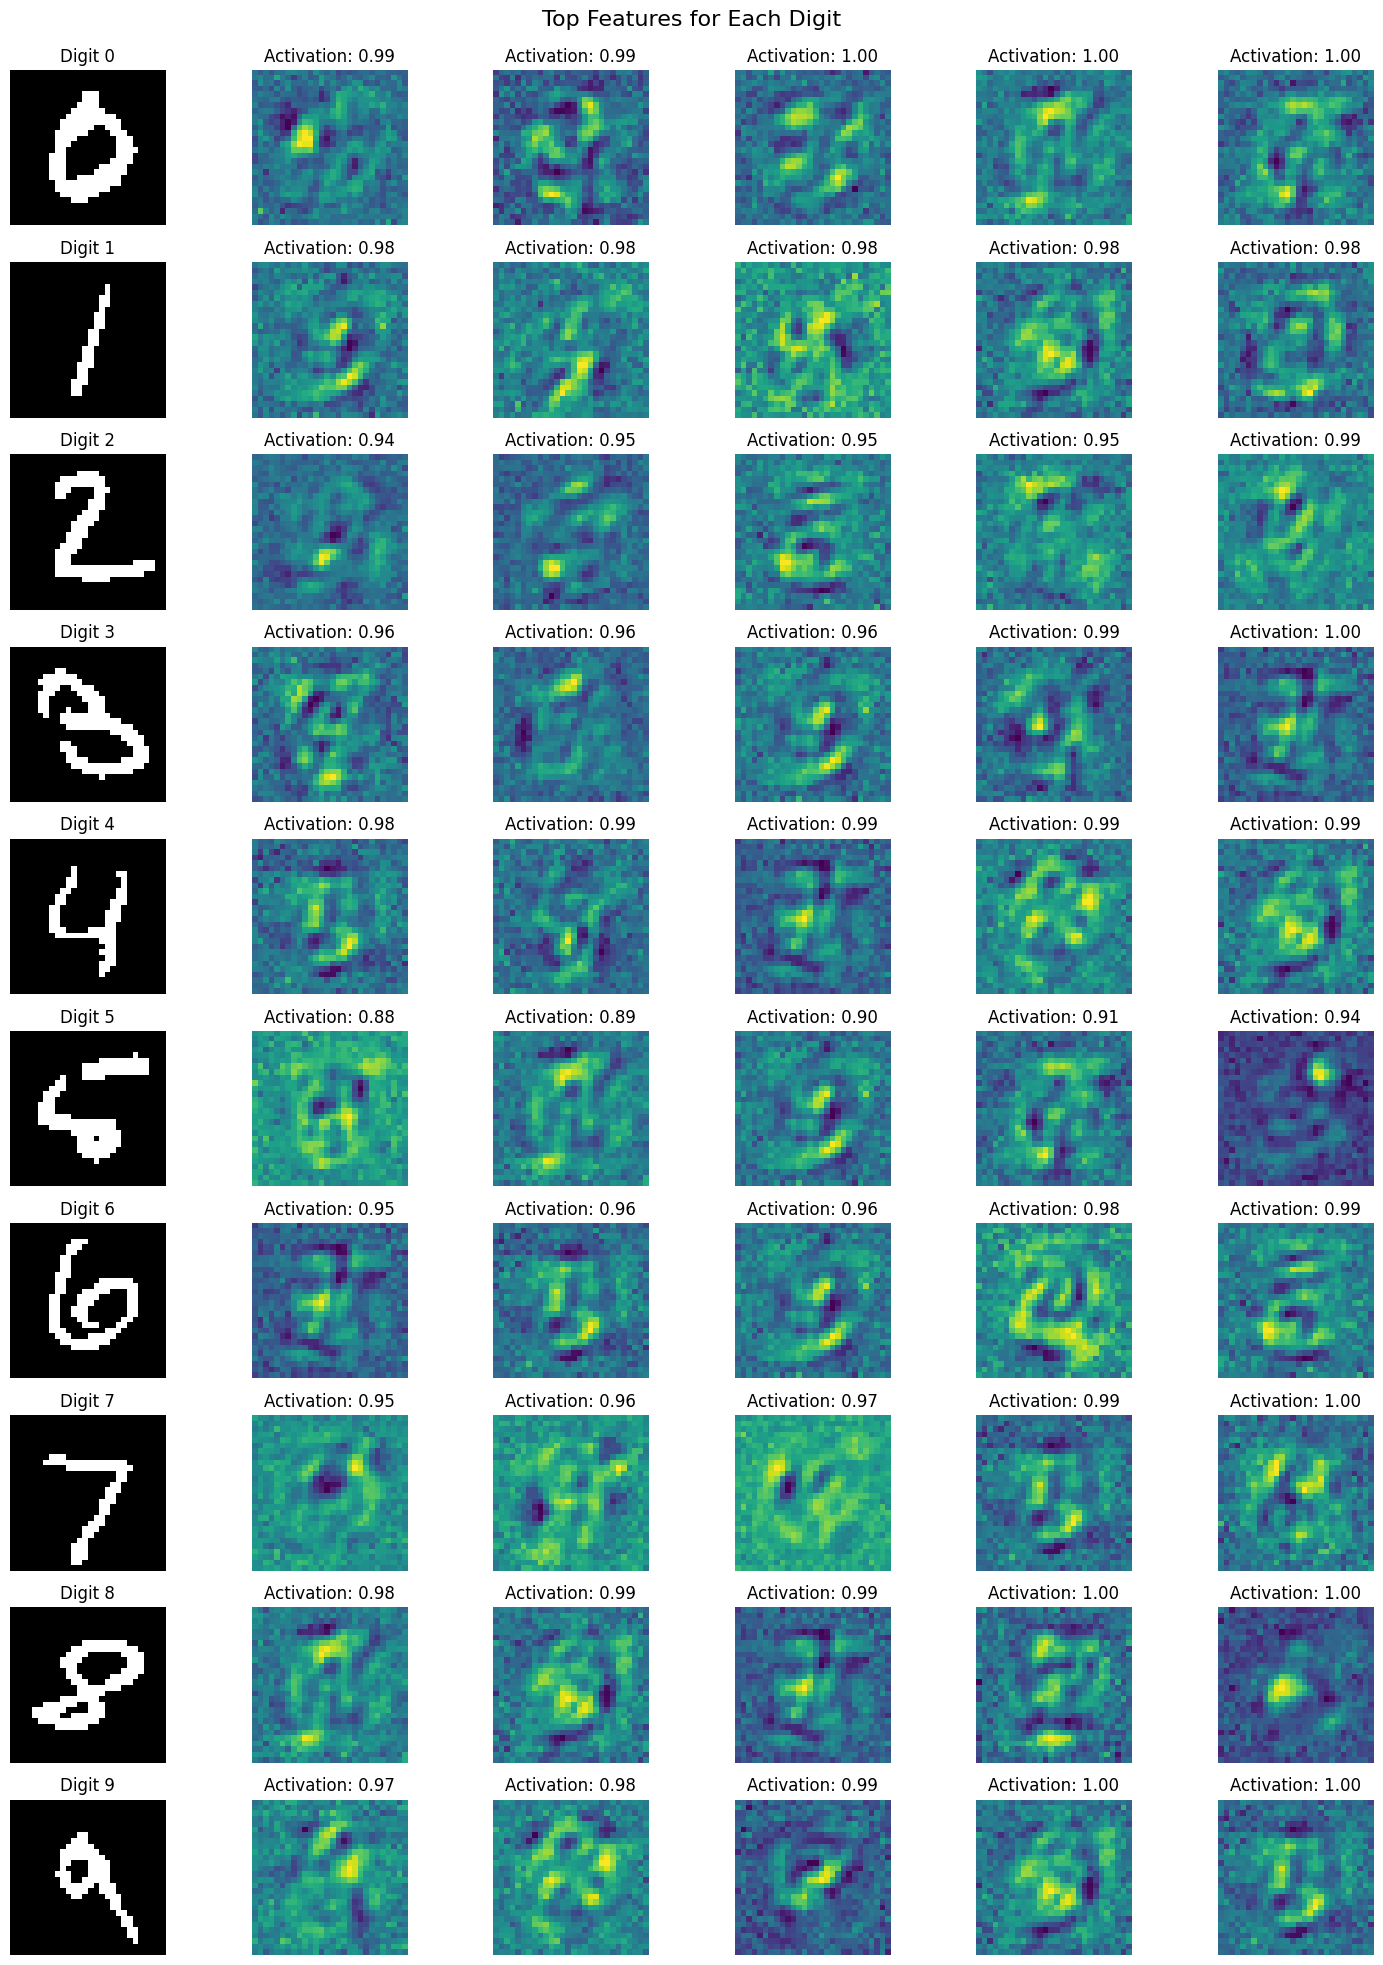

In [7]:
digit_samples, digit_features = analyze_digit_features(
    rbm, test_dataset, device=device, n_visible=n_visible
)
visualize_digit_features(rbm, digit_samples, digit_features)

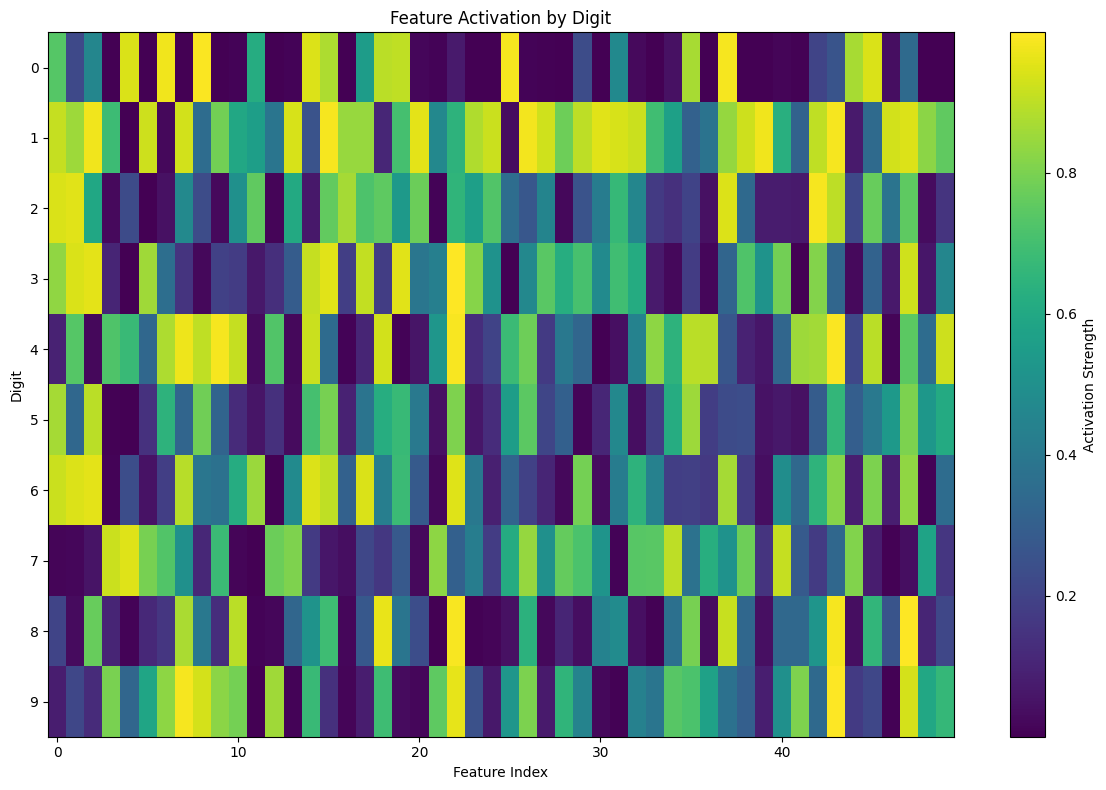

In [8]:
visualize_feature_heatmap(digit_features)

## Reconstruct MNIST Images

We can evaluate how well the RBM has learned the data distribution by comparing original test images with their reconstructions. We'll take a few images from the test set, pass them through one step of Gibbs sampling, and visualize the result.

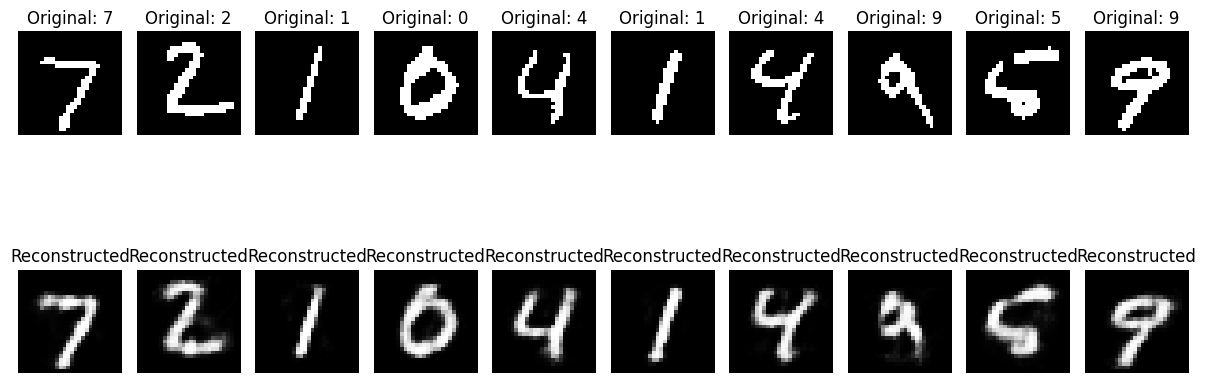

In [9]:
visualize_reconstructions(rbm, test_loader, device=device, n_samples=10)

## Generate New Samples

We can also generate new samples by starting with random noise and performing Gibbs sampling for many steps until the chain converges to the model's learned distribution.

100%|██████████| 1000/1000 [00:00<00:00, 4521.72it/s]


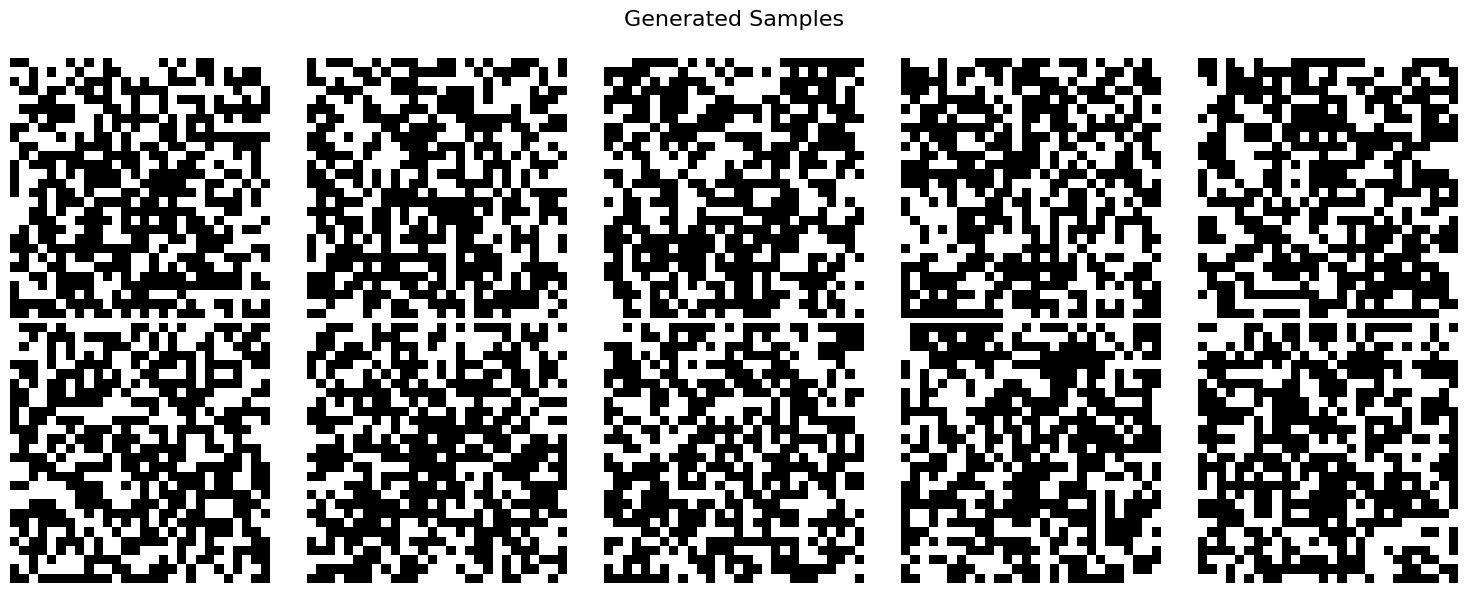

In [10]:
generated_samples = generate_samples(rbm, num_samples=10)
visualize_generated_samples(generated_samples, n_samples=10)

## Conclusion

We've successfully:
1. Imported and initialized an RBM model
2. Trained it on the MNIST dataset
3. Visualized the learned features
4. Tested the model's reconstruction capabilities
5. Generated new samples from the model

The RBM has learned to capture the main features of the MNIST digits and can both reconstruct existing digits and generate new ones.